# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy
import seawater as sw
from xhistogram.xarray import histogram


from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [2]:
from dask.distributed import Client

In [3]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=32e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/workshop007/proxy/8787/status,
Dashboard: /user/workshop007/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35669,Workers: 1
Dashboard: /user/workshop007/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.214.97:45985,Total threads: 8
Dashboard: /user/workshop007/proxy/45255/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:35587,


In [4]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [5]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('/data/spg_fresh_blob_202104_data/interim/')

outputPath = Path('data/interim/transitTimes/')
output_data_path = project_path / outputPath

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

figure_path = Path('reports/figures/transitTimes/')

year = 2000
nsubsets = 32


In [6]:
yearstr = str(year)

In [7]:

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file =  project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 1000 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2100000 / 2643886


max_current = 2.0

particle_section_area = max_current * osnap_subsection_length * osnap_subsection_depth / (2643886)

## Load endtrack data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [8]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(interim_data_path).glob(f"*.nc/")))


In [9]:
print(data_trackends_subsets)

[PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1990.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1991.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1992.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1993.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1994.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1995.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1996.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1997.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1998.nc'), PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_

In [10]:
ds = xr.concat(
    [xr.open_dataset(store,chunks={
        "ends": 2, "traj": 1048576
    }) for store in data_trackends_subsets],
    dim="traj",
)
# ds = xr.concat(
#     [xr.open_dataset(store) for store in data_trackends_subsets],
#     dim="traj",
# )

display(ds)
print(ds.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 142432653)
Dimensions without coordinates: ends, traj
Data variables: (12/16)
    trajectory       (ends, traj) float64 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    lat              (ends, traj) float64 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    lon              (ends, traj) float64 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    z                (ends, traj) float64 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    ...               ...
    LabCu_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    LC60W_is_path    (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    LCdir_is_path    (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    GulfS_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    other_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    north_of_osnap   (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

18.801110196 GiB


In [11]:
len(ds.traj) % 32

13

#### Subset tracks by OSNAP line cross longitude and depth range

In [12]:
lonRange=[-37,0]
depthRange=[0,500]
range_str = 'OsnapE_37W_0_500m'

In [13]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.where(ds.isel(ends=0).north_of_osnap == False)
ds = ds.dropna('traj', how='all')
    

In [14]:
deltaT = -1*ds.time.diff(dim='ends').squeeze()
ds["deltaT"]=deltaT

In [15]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 27469282)
Dimensions without coordinates: ends, traj
Data variables: (12/17)
    trajectory       (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(2, 205240), meta=np.ndarray>
    lat              (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    lon              (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    z                (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    ...               ...
    LC60W_is_path    (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    LCdir_is_path    (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    GulfS_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    other_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    north_of_osnap   (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    deltaT           (traj) timedelta64[ns] dask.array<chunksize=(205240,), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [16]:
ds = ds.drop(labels=['trajectory',
                     'lat',
                    'lon',
                    'z',
                    'mxl',
                    'temp',
                    'salt',
                    'uvel',
                    'vvel',
                    'north_of_osnap'])

In [17]:
tail = len(ds.traj) % 32
ds_subsets = xr.concat(
    [ds.isel(traj=slice(subsetno,-tail,nsubsets))
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [18]:
ds_subsets = ds_subsets.isel(ends=0)

In [19]:
ds_subsets = ds_subsets.compute()

In [20]:
# ds_subsets = ds_subsets.chunk(chunks={'subsetno':1,'traj':1000000})

In [21]:
deltaT = ds_subsets.deltaT

In [22]:
dstime = ds_subsets.time

In [23]:
deltaT_1990s = deltaT.where(dstime < np.datetime64('2000-01-01T00:00:00'))

In [24]:
deltaT_2000s = deltaT.where((dstime > np.datetime64('2000-01-01T00:00:00')) &
                        (dstime < np.datetime64('2010-01-01T00:00:00')))


In [25]:
deltaT_2010s = deltaT.where((dstime > np.datetime64('2010-01-01T00:00:00')) &
                        (dstime < np.datetime64('2020-01-01T00:00:00')))


In [26]:
deltaT_1990s

<xarray.DataArray 'deltaT' (subsetno: 32, traj: 858415)>
array([[175824000000000000, 113184000000000000,  74736000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [ 99360000000000000,  60048000000000000, 116208000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [ 57456000000000000, 315360000000000000,  69552000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       ...,
       [ 80352000000000000,  37584000000000000,  46656000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [160272000000000000, 102384000000000000,  72576000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [315360000000000000, 150336000000000000,  41904000000000000, ...,
                     'NaT',              'NaT',              'NaT']],
      dtype='timedelta64[ns]')
Dimensions without coordinates: subsetno, traj
Attributes:
    long_name:      
    standard_name:  time
    axis:           T

In [27]:
bins = np.linspace(0,3650,731)

In [28]:
h_total = histogram(deltaT.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu = histogram(deltaT.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs = histogram(deltaT.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [29]:
h_total_1990s = histogram(deltaT_1990s.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu_1990s = histogram(deltaT_1990s.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs_1990s = histogram(deltaT_1990s.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [30]:
h_total_2000s = histogram(deltaT_2000s.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu_2000s = histogram(deltaT_2000s.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs_2000s = histogram(deltaT_2000s.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [31]:
h_total_2010s = histogram(deltaT_2010s.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu_2010s = histogram(deltaT_2010s.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs_2010s = histogram(deltaT_2010s.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [32]:
def plot_hist_curve(ax,h,color,linestyle,nyears,label='',ntraj=1):
    h_mean = h.isel(days_bin=slice(0,-1,1)).mean(dim='subsetno')*100.0/ntraj
    h_std =  h.isel(days_bin=slice(0,-1,1)).std(dim='subsetno')*100.0/ntraj
    h_mean.plot(ax=ax,
                color=color,
                linestyle=linestyle,
                label=label)
    ax.fill_between(h_mean.days_bin,
                    h_mean+1.96*h_std,
                    h_mean-1.96*h_std,
                    color=color,
                    linewidth=0,
                    zorder=1,
                    alpha=0.2)
    return


In [33]:
ntraj_total = h_total.sum(dim='days_bin').mean(dim='subsetno')


Text(0, 0.5, 'percentage of particle')

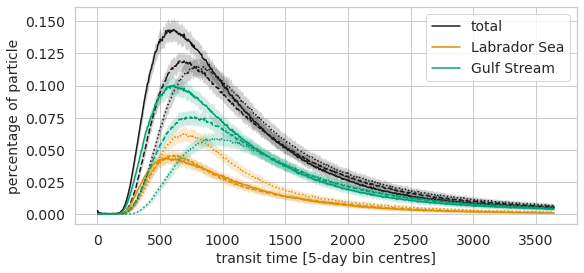

In [34]:
fig,ax = plt.subplots(1,figsize = (9,4),sharex=True)


plot_hist_curve(ax,h_total_1990s,'k','solid',10,'total',ntraj=ntraj_total)
plot_hist_curve(ax,h_total_2000s,'k','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_total_2010s,'k','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_labcu_1990s,'C1','solid',10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2000s,'C1','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2010s,'C1','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_gulfs_1990s,'C2','solid',10,'Gulf Stream',ntraj=ntraj_total)
plot_hist_curve(ax,h_gulfs_2000s,'C2','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_gulfs_2010s,'C2','dotted',10,ntraj=ntraj_total)

ax.legend()
ax.set_xlabel('transit time [5-day bin centres]')
ax.set_ylabel('percentage of particle')


In [35]:
h_lc60w = histogram(deltaT.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir = histogram(deltaT.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [36]:
h_lc60w_1990s = histogram(deltaT_1990s.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir_1990s = histogram(deltaT_1990s.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [37]:
h_lc60w_2000s = histogram(deltaT_2000s.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir_2000s = histogram(deltaT_2000s.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [38]:
h_lc60w_2010s = histogram(deltaT_2010s.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir_2010s = histogram(deltaT_2010s.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [46]:
h_total.to_netcdf(output_data_path / 'histogram_transit_time_total_all.nc')
h_total_1990s.to_netcdf(output_data_path / 'histogram_transit_time_total_1990s.nc')
h_total_2000s.to_netcdf(output_data_path / 'histogram_transit_time_total_2000s.nc')
h_total_2010s.to_netcdf(output_data_path / 'histogram_transit_time_total_2010s.nc')

h_labcu.to_netcdf(output_data_path / 'histogram_transit_time_labcu_all.nc')
h_labcu_1990s.to_netcdf(output_data_path / 'histogram_transit_time_labcu_1990s.nc')
h_labcu_2000s.to_netcdf(output_data_path / 'histogram_transit_time_labcu_2000s.nc')
h_labcu_2010s.to_netcdf(output_data_path / 'histogram_transit_time_labcu_2010s.nc')

h_gulfs.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_all.nc')
h_gulfs_1990s.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_1990s.nc')
h_gulfs_2000s.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_2000s.nc')
h_gulfs_2010s.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_2010s.nc')

h_lc60w.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_all.nc')
h_lc60w_1990s.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_1990s.nc')
h_lc60w_2000s.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_2000s.nc')
h_lc60w_2010s.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_2010s.nc')

h_lcdir.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_all.nc')
h_lcdir_1990s.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_1990s.nc')
h_lcdir_2000s.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_2000s.nc')
h_lcdir_2010s.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_2010s.nc')








Text(0, 0.5, 'scaled particle numbers')

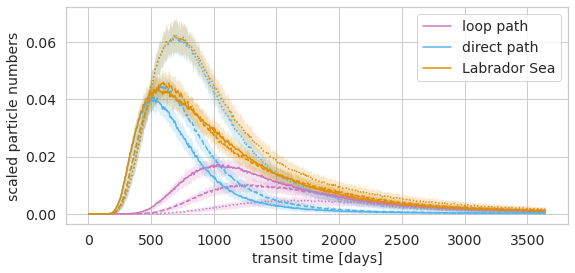

In [39]:
fig,ax = plt.subplots(1,figsize = (9,4),sharex=True)

# plot_hist_curve(ax,h_labcu_1990s,'C1','solid' ,10,'Labrador Sea')
# plot_hist_curve(ax,h_labcu_2000s,'C1','dashed',10)
# plot_hist_curve(ax,h_labcu_2010s,'C1','dotted',10)

plot_hist_curve(ax,h_lc60w_1990s,'C4','solid' ,10,'loop path',ntraj=ntraj_total)
plot_hist_curve(ax,h_lc60w_2000s,'C4','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_lc60w_2010s,'C4','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_lcdir_1990s,'C9','solid' ,10,'direct path',ntraj=ntraj_total)
plot_hist_curve(ax,h_lcdir_2000s,'C9','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_lcdir_2010s,'C9','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_labcu_1990s,'C1','solid' ,10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2000s,'C1','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2010s,'C1','dotted',10,ntraj=ntraj_total)


ax.legend()
ax.set_xlabel('transit time [days]')
ax.set_ylabel('scaled particle numbers')


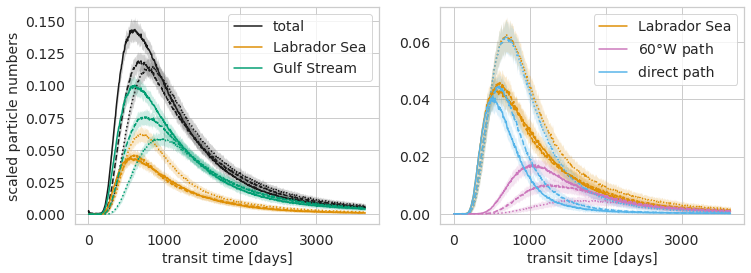

In [40]:
fig,ax = plt.subplots(1,2,figsize = (12,4),sharex=True)

plot_hist_curve(ax[0],h_total_1990s,'k','solid' ,10,'total',ntraj=ntraj_total)
plot_hist_curve(ax[0],h_total_2000s,'k','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax[0],h_total_2010s,'k','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax[0],h_labcu_1990s,'C1','solid' ,10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax[0],h_labcu_2000s,'C1','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax[0],h_labcu_2010s,'C1','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax[0],h_gulfs_1990s,'C2','solid' ,10,'Gulf Stream',ntraj=ntraj_total)
plot_hist_curve(ax[0],h_gulfs_2000s,'C2','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax[0],h_gulfs_2010s,'C2','dotted',10,ntraj=ntraj_total)

ax[0].legend()
ax[0].set_xlabel('transit time [days]')
ax[0].set_ylabel('scaled particle numbers')

plot_hist_curve(ax[1],h_labcu_1990s,'C1','solid',10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax[1],h_labcu_2000s,'C1','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax[1],h_labcu_2010s,'C1','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax[1],h_lc60w_1990s,'C4','solid',10,'60$\degree$W path',ntraj=ntraj_total)
plot_hist_curve(ax[1],h_lc60w_2000s,'C4','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax[1],h_lc60w_2010s,'C4','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax[1],h_lcdir_1990s,'C9','solid',10,'direct path',ntraj=ntraj_total)
plot_hist_curve(ax[1],h_lcdir_2000s,'C9','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax[1],h_lcdir_2010s,'C9','dotted',10,ntraj=ntraj_total)

ax[1].legend()
ax[1].set_xlabel('transit time [days]')
ax[1].set_ylabel('')

plt.savefig(project_path / figure_path / Path('transittime_decades.png'),dpi=300)
plt.savefig(project_path / figure_path / Path('transittime_decades.pdf'))



In [41]:
ds_subsets = ds_subsets.assign_coords({'subsetno':ds_subsets.subsetno})
ds_subsets = ds_subsets.assign_coords({'traj':ds_subsets.traj})


In [42]:
ds_subsets

<xarray.Dataset>
Dimensions:          (subsetno: 32, traj: 858415)
Coordinates:
  * subsetno         (subsetno) int64 0 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
  * traj             (traj) int64 0 1 2 3 4 ... 858411 858412 858413 858414
Data variables:
    time             (subsetno, traj) datetime64[ns] 1990-01-03T12:00:00 ... ...
    LabCu_is_source  (subsetno, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LC60W_is_path    (subsetno, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LCdir_is_path    (subsetno, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    GulfS_is_source  (subsetno, traj) float64 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0
    other_is_source  (subsetno, traj) float64 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0
    deltaT           (subsetno, traj) timedelta64[ns] 2035 days ... 1435 days
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [70]:
ds_subsets_dt_annualmean_total = (ds_subsets.
                                        deltaT.groupby(ds_subsets.time.dt.year).mean())
ds_subsets_dt_annualmean_labCu = (ds_subsets.
                                        where(ds_subsets.LabCu_is_source).
                                        deltaT.groupby(ds_subsets.time.dt.year).mean())
ds_subsets_dt_annualmean_GulfS = (ds_subsets.
                                        where(ds_subsets.GulfS_is_source).
                                        deltaT.groupby(ds_subsets.time.dt.year).mean())
ds_subsets_dt_annualmean_lc60w = (ds_subsets.
                                        where(ds_subsets.LC60W_is_path).
                                        deltaT.groupby(ds_subsets.time.dt.year).mean())
ds_subsets_dt_annualmean_lcdir = (ds_subsets.
                                        where(ds_subsets.LCdir_is_path).
                                        deltaT.groupby(ds_subsets.time.dt.year).mean())

In [73]:
def plot_transit_timeseries():
    fig, ax = plt.subplots(figsize=(8,3))
    
    nsperday=24*3600*1000000000.0

    (ds_subsets_dt_annualmean_total/nsperday).plot(ax=ax,color='k')
    (ds_subsets_dt_annualmean_labCu/nsperday).plot(ax=ax,color='C1')
    (ds_subsets_dt_annualmean_GulfS/nsperday).plot(ax=ax,color='C2')
    (ds_subsets_dt_annualmean_lc60w/nsperday).plot(ax=ax,color='C4')
    (ds_subsets_dt_annualmean_lcdir/nsperday).plot(ax=ax,color='C9')

    ax.set_xlabel('')
    ax.set_ylabel('transit time [days]')
    ax.set_xlim(right=2024.5)
    
    ax.text(0.87,0.6,'all',transform=ax.transAxes, color='k')
    ax.text(0.87,0.35,'Lab Sea',transform=ax.transAxes, color='C1')
    ax.text(0.87,0.5,'Gulf Str',transform=ax.transAxes, color='C2')
    ax.text(0.87,0.9,'loop',transform=ax.transAxes, color='C4')
    ax.text(0.87,0.25,'direct',transform=ax.transAxes, color='C9')
    
    plt.savefig(project_path / figure_path / 'transit_timeseries',dpi=300, bbox_inches='tight')
    
    return

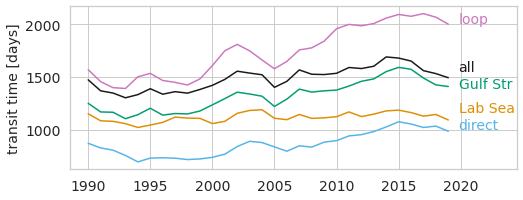

In [90]:
plot_transit_timeseries()

In [75]:
ds_dt_5daymean_total = xr.concat(
    [ds_subsets.isel(subsetno=subsetno)
       .groupby("time").mean()
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [79]:
ds_dt_5daymean_labcu = xr.concat(
    [ds_subsets.isel(subsetno=subsetno)
       .where(ds_subsets.isel(subsetno=subsetno).LabCu_is_source)
       .groupby("time").mean()
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [80]:
ds_dt_5daymean_gulfs = xr.concat(
    [ds_subsets.isel(subsetno=subsetno)
       .where(ds_subsets.isel(subsetno=subsetno).GulfS_is_source)
       .groupby("time").mean()
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [81]:
ds_dt_5daymean_lc60w = xr.concat(
    [ds_subsets.isel(subsetno=subsetno)
       .where(ds_subsets.isel(subsetno=subsetno).LC60W_is_path)
       .groupby("time").mean()
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [82]:
ds_dt_5daymean_lcdir = xr.concat(
    [ds_subsets.isel(subsetno=subsetno)
       .where(ds_subsets.isel(subsetno=subsetno).LCdir_is_path)
       .groupby("time").mean()
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [85]:
ds_dt_5daymean_total.to_netcdf(output_data_path / 'transit_time_5daymean_total.nc')
ds_dt_5daymean_labcu.to_netcdf(output_data_path / 'transit_time_5daymean_labcu.nc')
ds_dt_5daymean_gulfs.to_netcdf(output_data_path / 'transit_time_5daymean_gulfs.nc')
ds_dt_5daymean_lc60w.to_netcdf(output_data_path / 'transit_time_5daymean_lc60w.nc')
ds_dt_5daymean_lcdir.to_netcdf(output_data_path / 'transit_time_5daymean_lcdir.nc')


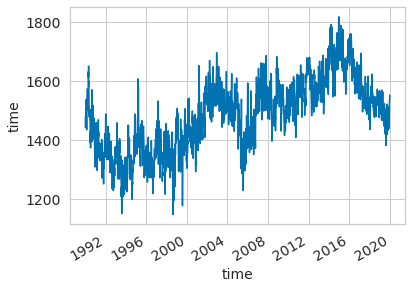

In [96]:
(ds_dt_5daymean_total.mean(dim='subsetno').deltaT/nsperday).plot()

NameError: name 'ds_dt_5daymean_total' is not defined

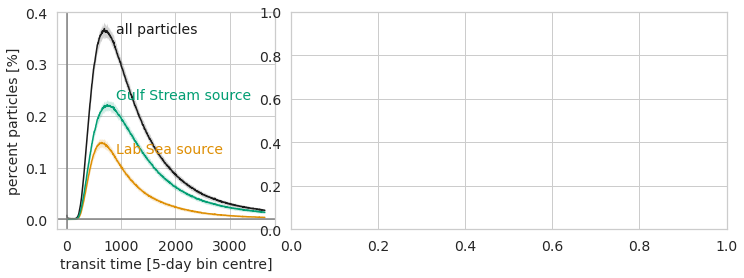

In [43]:
def plot_ts_with_errorbars(ds,roll,ax,colour,label='',dashes=[]):

    rolling = (ds.mean(dim='subsetno').rolling(time=roll,center=True).mean())
    std = (ds.rolling(time=roll,center=True).mean()).std(dim='subsetno')
    rolling.plot(ax=ax,color=colour,zorder=10,label=label,dashes=dashes)
    ax.fill_between(ds.time.data,rolling+1.96*std,rolling-1.96*std,color=colour,zorder=1,alpha=0.4,linewidth=0)
    return


fig,ax = plt.subplots(1,2,figsize = (12,4),gridspec_kw={'width_ratios': [1, 2],'wspace':0.05})

plot_hist_curve(ax[0],h_total,'k','solid' ,10,'total',ntraj=ntraj_total)
plot_hist_curve(ax[0],h_labcu,'C1','solid' ,10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax[0],h_gulfs,'C2','solid' ,10,'Gulf Stream',ntraj=ntraj_total)

ax[0].set_xlabel('transit time [5-day bin centre]')
ax[0].set_ylabel('percent particles [%]')
ax[0].axhline(color='gray')   
ax[0].axvline(color='gray')   

ax[0].text(0.27,0.9,'all particles',transform=ax[0].transAxes, color='k')
ax[0].text(0.27,0.35,'Lab Sea source',transform=ax[0].transAxes, color='C1')
ax[0].text(0.27,0.6,'Gulf Stream source',transform=ax[0].transAxes, color='C2')

nsperday=24*3600*1000000000.0

plot_ts_with_errorbars((ds_dt_5daymean_total.deltaT.astype(int)/nsperday),18,ax=ax[1],colour='k')
plot_ts_with_errorbars((ds_dt_5daymean_labcu.deltaT.astype(int)/nsperday),18,ax=ax[1],colour='C1')
plot_ts_with_errorbars((ds_dt_5daymean_gulfs.deltaT.astype(int)/nsperday),18,ax=ax[1],colour='C2')
plot_ts_with_errorbars((ds_dt_5daymean_lc60w.deltaT.astype(int)/nsperday),18,ax=ax[1],colour='C4')
plot_ts_with_errorbars((ds_dt_5daymean_lcdir.deltaT.astype(int)/nsperday),18,ax=ax[1],colour='C9')

ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()    
ax[1].set_xlabel('')
ax[1].set_ylabel('transit time [days]')
ax[1].set_ylim(bottom=0)

ax[1].text(0.87,0.74,'all',transform=ax[1].transAxes, color='k')
ax[1].text(0.25,0.38,'Lab Sea',transform=ax[1].transAxes, color='C1')
ax[1].text(0.72,0.56,'Gulf Stream',transform=ax[1].transAxes, color='C2')
ax[1].text(0.6,0.9,'loop',transform=ax[1].transAxes, color='C4')
ax[1].text(0.6,0.30,'direct',transform=ax[1].transAxes, color='C9')

ax[1].axhline(color='gray')   
plt.savefig(project_path / figure_path / 'transit_times_forpaper.png',dpi=300, bbox_inches='tight')

    